# Drop Features with High PSI Value

The **DropHighPSIFeatures** selects features based on the Population Stability Index (PSI). The higher this value, the more unstable a feature. Unstable in this case means that there is a significant change in the distribution of the feature in the groups being compared.

To determine the PSI of a feature, the DropHighPSIFeatures takes a dataframe and splits it in 2 based on a reference variable indicated by the user. This reference variable can be numerical, categorical or date. If the variable is numerical, the split ensures a certain proportion of observations in each sub-dataframe. If the variable is categorical, we can split the data based on the categories. And if the variable is a date, we can split the data based on dates.

**In this notebook, we showcase many possible ways in which the DropHighPSIFeatures can be used to select features based on their PSI value.**

### Dataset

We use the Credit Approval data set from the UCI Machine Learning Repository.

To download the Credit Approval dataset from the UCI Machine Learning Repository visit [this website](http://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/) and click on crx.data to download data. Save crx.data to the parent folder of this notebook folder.

**Citation:**

Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

# Data preparation

We will edit some of the original variables and add some additional features to simulate different scenarios.

In [1]:
from datetime import date

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from feature_engine.selection import DropHighPSIFeatures

## Load the data

In [2]:
# load data
data = pd.read_csv('../crx.data', header=None)

# add variable names according to UCI Machine Learning
# Repo information
data.columns = ['A'+str(s) for s in range(1,17)]

# replace ? by np.nan
data = data.replace('?', np.nan)

# re-cast some variables to the correct types 
data['A2'] = data['A2'].astype('float')
data['A14'] = data['A14'].astype('float')

# encode target as binary
data['A16'] = data['A16'].map({'+':1, '-':0})

data.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202.0,0,1
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43.0,560,1
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,280.0,824,1
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100.0,3,1
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120.0,0,1


## Edit and add features

In [3]:
# simulate customers from different portfolios.
data['A13'] = data['A13'].map({'g':'portfolio_1', 's':'portfolio_2', 'q':'portfolio_3'})
data['A13'].fillna('Unknown', inplace=True)

# simulate customers from different channels
data['A12'] = data['A12'].map({'f':'wholesale', 't':'retail'})
data['A12'].fillna('Missing', inplace=True)

In [4]:
# simulate customers from different age groups

data['A6'].fillna('Missing', inplace=True)

labels = {
'w': '20-25',
'q': '25-30',
'm': '30-35',
'r': '35-40',
'cc': '40-45',
'k': '45-50',
'c': '50-55',
'd': '55-60',
'x': '60-65',
'i': '65-70',
'e': '70-75',
'aa': '75-80',
'ff': '85-90',
'j': 'Unknown',
'Missing': 'Missing',
}
    
data['A6'] = data['A6'].map(labels)

In [5]:
# add a datetime variable

data['date'] = pd.date_range(start='1/1/2018', periods=len(data))

data.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16,date
0,b,30.83,0.000,u,g,20-25,v,1.25,t,t,1,wholesale,portfolio_1,202.0,0,1,2018-01-01
1,a,58.67,4.460,u,g,25-30,h,3.04,t,t,6,wholesale,portfolio_1,43.0,560,1,2018-01-02
2,a,24.50,0.500,u,g,25-30,h,1.50,t,f,0,wholesale,portfolio_1,280.0,824,1,2018-01-03
3,b,27.83,1.540,u,g,20-25,v,3.75,t,t,5,retail,portfolio_1,100.0,3,1,2018-01-04
4,b,20.17,5.625,u,g,20-25,v,1.71,t,f,0,wholesale,portfolio_2,120.0,0,1,2018-01-05


## Data Analysis

We will plot the distributions of numerical and categorical variables.

In [6]:
# categorical variables

vars_cat = data.select_dtypes(include='O').columns.to_list()

vars_cat

['A1', 'A4', 'A5', 'A6', 'A7', 'A9', 'A10', 'A12', 'A13']

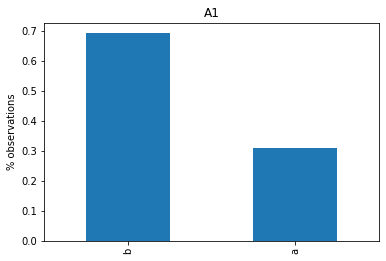

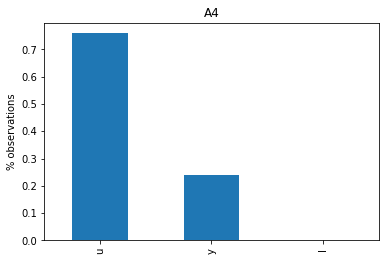

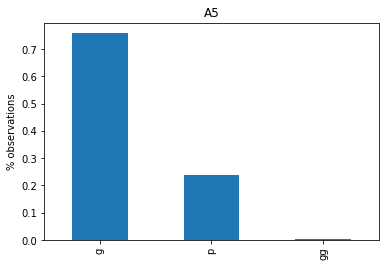

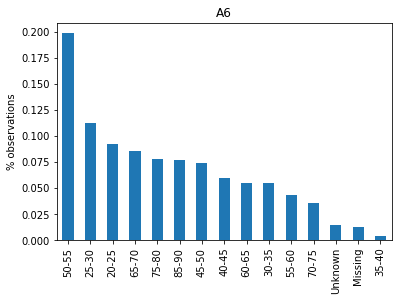

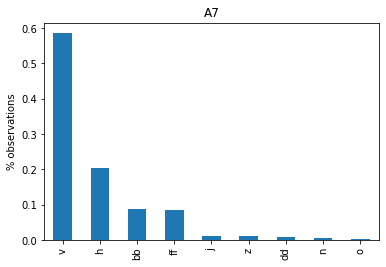

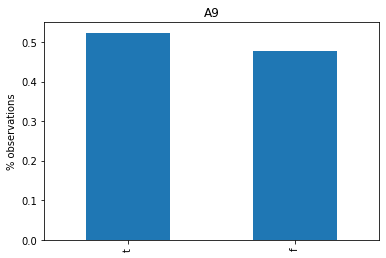

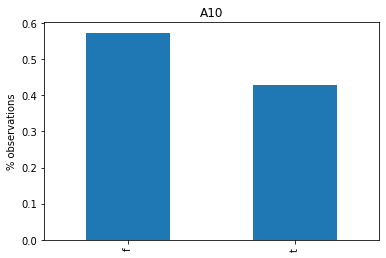

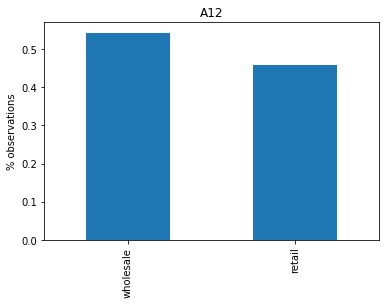

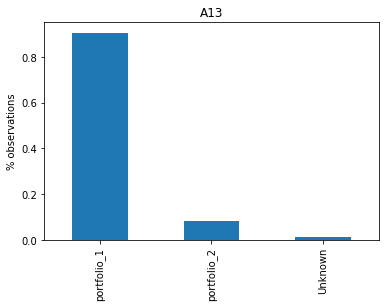

In [7]:
for var in vars_cat:
    data[var].value_counts(normalize=True).plot.bar()
    plt.title(var)
    plt.ylabel('% observations')
    plt.show()

In [8]:
# numerical variables

vars_num = data.select_dtypes(exclude='O').columns.to_list()

vars_num.remove('A16')

vars_num.remove('date')

vars_num

['A2', 'A3', 'A8', 'A11', 'A14', 'A15']

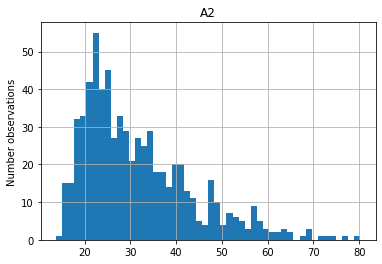

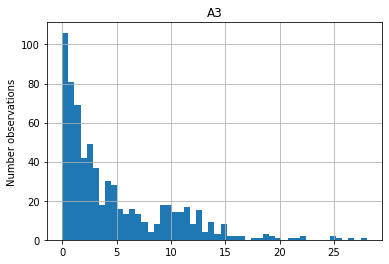

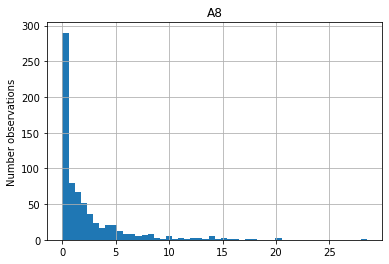

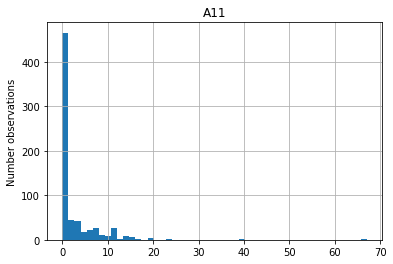

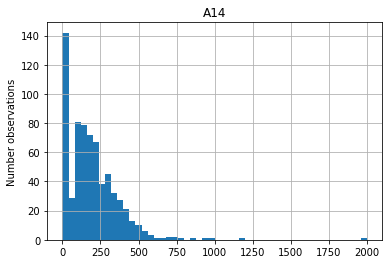

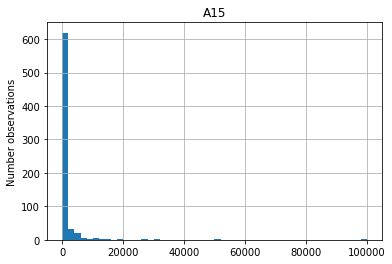

In [9]:
for var in vars_num:
    data[var].hist(bins=50)
    plt.title(var)
    plt.ylabel('Number observations')
    plt.show()

# PSI feature selection

## Split data based on proportions

DropHighPSIFeatures splits the dataset in 2, a base dataset and a comparison dataset. The comparison dataset is compared against the base dataset to determine the PSI.

We may want to divide the dataset just based on **proportion of observations**. We want to have, say, 60% of observations in the base dataset. We can use the **dataframe index** to guide the split.

**NOTE** that for the split, the transformer orders the variable, here the index, and then smaller values of the variable will be in the base dataset, and bigger values of the variable will go to the comparison dataset. In other words, this is not a random split.

In [10]:
# First, we split the data into a train and a test set

X_train, X_test, y_train, y_test = train_test_split(
    data[vars_cat+vars_num],
    data['A16'],
    test_size=0.1,
    random_state=42,
)

In [11]:
# Now we set up the DropHighPSIFeatures

transformer = DropHighPSIFeatures(
    split_frac=0.6, # the proportion of obs in the base dataset
    split_col=None, # If None, it uses the index
    strategy = 'equal_frequency', # whether to create the bins of equal frequency
    threshold=0.1, # the PSI threshold to drop variables
    variables=vars_num, # the variables to analyse
    missing_values='ignore',
)

In [12]:
# Now we fit the transformer to the train set
# Here, the transformer will split the data, 
# determine the PSI of each feature and identify
# those that will be removed.

transformer.fit(X_train)

DropHighPSIFeatures(missing_values='ignore', split_frac=0.6, threshold=0.1,
                    variables=['A2', 'A3', 'A8', 'A11', 'A14', 'A15'])

In [13]:
# the value in the index that determines the separation
# into base and comparison datasets. 

# Observations whose index value is smaller than 
# the cut_off will be in the base dataset. 
# The remaining ones in the comparison data.

transformer.cut_off_

415.0

In [14]:
# the PSI threshold above which variables 
# will be removed.

# We can change this when we initialize the transformer

transformer.threshold

0.1

In [15]:
# During fit() the transformer determines the PSI
# values for each variable and stores it.

transformer.psi_values_

{'A2': 0.0787531730176423,
 'A3': 0.08032153261330531,
 'A8': 0.1919536825616741,
 'A11': 0.04766182980880748,
 'A14': 0.10382066854104179,
 'A15': 0.020778411016241834}

In [16]:
# The variables that will be dropped:
# those whose PSI is biggher than the threshold.

transformer.features_to_drop_

['A8', 'A14']

To understand what the DropHighPSIFeatures is doing, let's split the train set manually, in the same what that the transformer is doing. Then, let's plot the distribution of the variables in each of the sub-dataframes.

Text(0.5, 1.0, 'A8 - moderately big PSI')

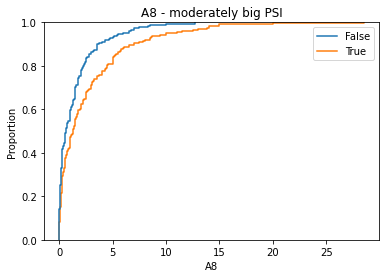

In [17]:
# Let's plot the variables distribution
# in each of the dataset portions

# create series to flag if an observation belongs to
# the base or comparison dataframe.

# Note how we use the cut_off identified by the
# transformer
tmp = X_train.index <= transformer.cut_off_

# plot
sns.ecdfplot(data=X_train, x='A8', hue=tmp)
plt.title('A8 - moderately big PSI')

Text(0.5, 1.0, 'A2 - low PSI')

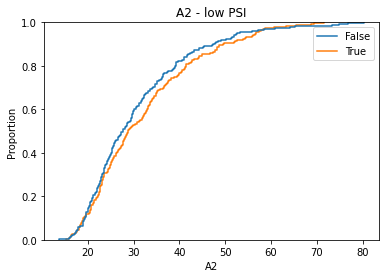

In [18]:
# For comparison, let's plot a variable with low PSI

sns.ecdfplot(data=X_train, x='A2', hue=tmp)
plt.title('A2 - low PSI')

We see that the cumulative distribution of A8 is different in both datasets and this is why it is flagged for removal. On the other hand, the cumulative distribution of A2 is not different in the sub-datasets.

Now we can go ahead and drop the features from the train and test sets.

In [19]:
# print shape before dropping variables

X_train.shape, X_test.shape

((621, 15), (69, 15))

In [20]:
X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)

# print shape **after** dropping variables

X_train.shape, X_test.shape

((621, 13), (69, 13))

The datasets have now 2 variables less, those that had high PSI values.

## Split data based on categorical values

In the previous example, we sorted the observations based on a numerical variable, the index, and then we assigned the top 60% of the observations to the base dataframe. 

Now, we will sort the observations based on a categorical variable, and assign the top 50% to the base dataframe.

**Note** when splitting based on categorical variables the proportions achieved after the split may not match exactly the one specified.

### When is this split useful?

This way of splitting the data is useful when, for example, we have a variable with the customer's ID. The ID's normally increase in time, with smaller values corresponding to older customers and bigger ID values corresponding to newly acquired customers.

**Our example**

In our data, we have customers from different age groups. We want to know if the variable distribution in younger age groups differ from older age groups. This is a suitable case to split based on a categorical value without specifically specifying the cut_off.

The transformer will sort the categories of the variable and then those with smaller category values will be in the base dataframe, and the remaining in the comparison dataset.

In [21]:
# First, we split the data into a train and a test set

X_train, X_test, y_train, y_test = train_test_split(
    data[vars_cat+vars_num],
    data['A16'],
    test_size=0.1,
    random_state=42,
)

In [22]:
# Now, we set up the transformer

# Note that if we do not specify which variables to analyse, 
# the transformer will find the numerical variables automatically

transformer = DropHighPSIFeatures(
    split_frac=0.5, # percentage of observations in base df
    split_col='A6', # the categorical variable with the age groups
    strategy = 'equal_frequency',
    threshold=0.1,
    variables=None, # When None, finds numerical variables automatically
    missing_values='ignore',
)

In [23]:
# Now we fit the transformer to the train set
# Here, the transformer will split the data, 
# determine the PSI of each feature and identify
# those that will be removed.

transformer.fit(X_train)

DropHighPSIFeatures(missing_values='ignore', split_col='A6', threshold=0.1)

In [24]:
# The transformer identified the numerical variables

transformer.variables_

['A2', 'A3', 'A8', 'A11', 'A14', 'A15']

In [25]:
# the age group under which, observations will be
# in the base df.

transformer.cut_off_

'45-50'

In [26]:
# The PSI values determined for each feature

transformer.psi_values_

{'A2': 0.09038144043568247,
 'A3': 0.07032227293449861,
 'A8': 0.1282158612755157,
 'A11': 0.04022018034673045,
 'A14': 0.09903792814701158,
 'A15': 0.021274805073497518}

In [27]:
# The variables that will be dropped.

transformer.features_to_drop_

['A8']

To understand what the DropHighPSIFeatures is doing, let's split the train set manually, in the same what that the transformer is doing. Then, let's plot the distribution of the variables in each of the sub-dataframes.

Text(0.5, 1.0, 'A8 - moderately big PSI')

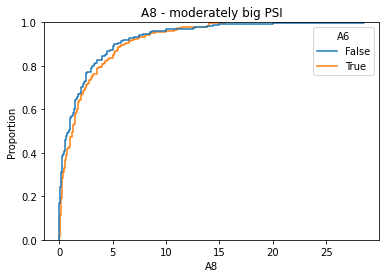

In [28]:
# Let's plot the variables distribution
# in each of the dataset portions

# create series to flag if an observation belongs to
# the base or comparison dataframe.

# Note how we use the cut_off identified by the
# transformer
tmp = X_train['A6'] <= transformer.cut_off_

# plot
sns.ecdfplot(data=X_train, x='A8', hue=tmp)
plt.title('A8 - moderately big PSI')

Text(0.5, 1.0, 'A15 - low PSI')

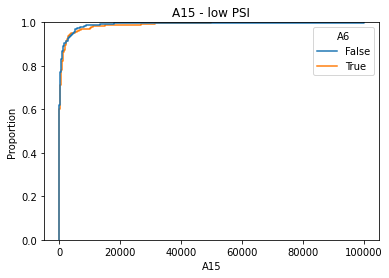

In [29]:
# For comparison, let's plot a variable with low PSI

sns.ecdfplot(data=X_train, x='A15', hue=tmp)
plt.title('A15 - low PSI')

The difference in the cumulative distributions of these groups wasn't very obvious :/

Now, let's identify which observations were assigned to each sub-dataframe by the transformer.

In [30]:
# The observations belonging to these age groups
# were assigned to the base df.

X_train[tmp]['A6'].unique()

array(['20-25', '25-30', '30-35', '40-45', '45-50', '35-40'], dtype=object)

In [31]:
# The number of age groups in the base df

X_train[tmp]['A6'].nunique()

6

In [32]:
# Proportion of observations in the base df

len(X_train[tmp]['A6']) / len(X_train)

0.4106280193236715

Note that we aimed for 50% of observations in the base reference, but based on this categorical variable, the closer we could get is 41%.

In [33]:
# The observations belonging to these age groups
# were assigned to the comparison df.

X_train[~tmp]['A6'].unique()

array(['60-65', '50-55', '70-75', '65-70', '75-80', '55-60', '85-90',
       'Unknown', 'Missing'], dtype=object)

In [34]:
# The number of age groups in the comparison df

X_train[~tmp]['A6'].nunique()

9

In [35]:
# Proportion of observations in the comparison df

len(X_train[~tmp]['A6']) / len(X_train)

0.5893719806763285

Note that we have more age groups in the comparison df, but these groups have fewer observations, so the proportion of observations in the base and comparison dfs is the closest possible to what we wanted: 50%.

Now we can go ahead and drop the features from the train and test sets.

In [36]:
# print shape before dropping variables

X_train.shape, X_test.shape

((621, 15), (69, 15))

In [37]:
X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)

# print shape **after** dropping variables

X_train.shape, X_test.shape

((621, 14), (69, 14))

## Split data based on distinct values

In the previous example, we split the data using a categorical variable as guide, but ultimately, the split was done based on proportion of observations.

In the extreme example where 50% of our customers belong to the age group 20-25 and the remaining 50% belong to older age groups, we would have only 1 age group in the base dataframe and all the remaining in the comparison dataframe if we split as we did in our previous example. This may result in a biased comparison.

If we want to ensure that we have 50% of the possible age groups in each base and comparison dataframe, we can do so with the parameter `split_distinct`.

In [38]:
# First, we split the data into a train and a test set

X_train, X_test, y_train, y_test = train_test_split(
    data[vars_cat+vars_num],
    data['A16'],
    test_size=0.1,
    random_state=42,
)

In [39]:
transformer = DropHighPSIFeatures(
    split_frac=0.5, # proportion of (unique) categories in the base df
    split_distinct=True, # we split based on unique categories
    split_col='A6', # the categorical variable guiding the split
    strategy = 'equal_frequency',
    threshold=0.1,
    missing_values='ignore',
)

In [40]:
# Now we fit the transformer to the train set
# Here, the transformer will split the data, 
# determine the PSI of each feature and identify
# those that will be removed.

transformer.fit(X_train)

DropHighPSIFeatures(missing_values='ignore', split_col='A6',
                    split_distinct=True, threshold=0.1)

In [41]:
# the age group under which, observations will be
# in the base df.

transformer.cut_off_

'55-60'

Note that this cut_off is different from the one we obtained previously.

In [42]:
# The PSI values determined for each feature

transformer.psi_values_

{'A2': 0.1323426708225364,
 'A3': 0.10997847648775538,
 'A8': 0.4245269976390187,
 'A11': 0.07282952117224366,
 'A14': 0.0920081845120618,
 'A15': 0.031059895072444714}

In [43]:
# The variables that will be dropped.

transformer.features_to_drop_

['A2', 'A3', 'A8']

To understand what the DropHighPSIFeatures is doing, let's split the train set manually, in the same what that the transformer is doing. Then, let's plot the distribution of the variables in each of the sub-dataframes.

Text(0.5, 1.0, 'A3 - moderately big PSI')

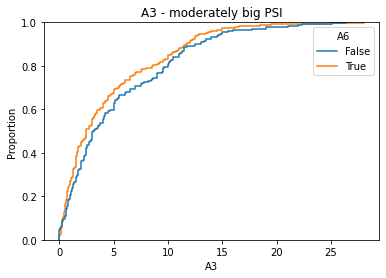

In [44]:
# Let's plot the variables distribution
# in each of the dataset portions

# create series to flag if an observation belongs to
# the base or comparison dataframe.

# Note how we use the cut_off identified by the
# transformer
tmp = X_train['A6'] <= transformer.cut_off_

# plot
sns.ecdfplot(data=X_train, x='A3', hue=tmp)
plt.title('A3 - moderately big PSI')

Text(0.5, 1.0, 'A15 - low PSI')

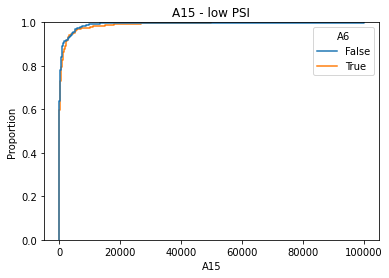

In [45]:
# For comparison, let's plot a variable with low PSI

sns.ecdfplot(data=X_train, x='A15', hue=tmp)
plt.title('A15 - low PSI')

We can see a difference in the distribution of the variable in the base and comparison dfs, when the PSI value is higher.

Now, let's identify which observations were assigned to each sub-dataframe by the transformer.

In [46]:
# The observations belonging to these age groups
# were assigned to the base df.

X_train[tmp]['A6'].unique()

array(['20-25', '25-30', '30-35', '50-55', '40-45', '45-50', '55-60',
       '35-40'], dtype=object)

In [47]:
# The number of age groups in the base df

X_train[tmp]['A6'].nunique()

8

In [48]:
# Proportion of observations in the base df

len(X_train[tmp]['A6']) / len(X_train)

0.6473429951690821

In [49]:
# The observations belonging to these age groups
# were assigned to the comparison df.

X_train[~tmp]['A6'].unique()

array(['60-65', '70-75', '65-70', '75-80', '85-90', 'Unknown', 'Missing'],
      dtype=object)

In [50]:
# The number of age groups in the comparison df

X_train[~tmp]['A6'].nunique()

7

In [51]:
# Proportion of observations in the comparison df

len(X_train[~tmp]['A6']) / len(X_train)

0.3526570048309179

Now, we have a similar proportion of age groups in the base and comparison dfs. But the proportion of observations is different.

Now we can go ahead and drop the features from the train and test sets.

In [52]:
# print shape before dropping variables

X_train.shape, X_test.shape

((621, 15), (69, 15))

In [53]:
X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)

# print shape **after** dropping variables

X_train.shape, X_test.shape

((621, 12), (69, 12))

## Split based on specific categories

In the previous example, the categories had an intrinsic order. What if, we want to split based on category values which do not have an intrinsic order?

We can do so by specifying which category values should go to the base dataframe.

This way of splitting the data is useful if we want to compare features across customers coming from different portfolios, or different sales channels.

In [54]:
# First, we split the data into a train and a test set

X_train, X_test, y_train, y_test = train_test_split(
    data[vars_cat+vars_num],
    data['A16'],
    test_size=0.1,
    random_state=42,
)

In [55]:
# Set up the transformer 

transformer = DropHighPSIFeatures(
    cut_off=['portfolio_2', 'portfolio_3'], # the categories that should be in the base df
    split_col='A13', # the categorical variable guiding the split
    strategy = 'equal_width', # the intervals are equidistant
    bins=5, # the number of intervals into which to sort the numerical values
    threshold=0.1,
    variables=vars_num,
    missing_values='ignore',
)

In [56]:
# Now we fit the transformer to the train set
# Here, the transformer will split the data, 
# determine the PSI of each feature and identify
# those that will be removed.

transformer.fit(X_train)

DropHighPSIFeatures(bins=5, cut_off=['portfolio_2', 'portfolio_3'],
                    missing_values='ignore', split_col='A13',
                    strategy='equal_width', threshold=0.1,
                    variables=['A2', 'A3', 'A8', 'A11', 'A14', 'A15'])

In [57]:
# We specified the cut_off, so we should see
# the portfolios here

transformer.cut_off_

['portfolio_2', 'portfolio_3']

In [58]:
# The transformer stores the PSI values of the variables

transformer.psi_values_

{'A2': 0.13707857211682517,
 'A3': 0.303619276042116,
 'A8': 0.27838798269892046,
 'A11': 0.9122686983242587,
 'A14': 0.2335366079238287,
 'A15': 2.1597917735884997}

In [59]:
# The variables that will be dropped.

transformer.features_to_drop_

['A2', 'A3', 'A8', 'A11', 'A14', 'A15']

It looks like all variables will be dropped.

To understand what the DropHighPSIFeatures is doing, let's split the train set manually, in the same what that the transformer is doing. Then, let's plot the distribution of the variables in each of the sub-dataframes.

<AxesSubplot:xlabel='A3', ylabel='Proportion'>

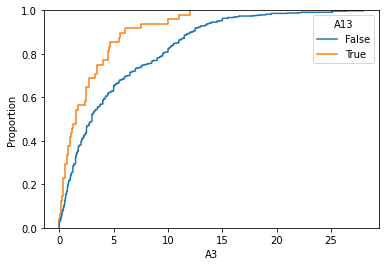

In [60]:
# Let's plot the variables distribution
# in each of the dataset portions

# create series to flag if an observation belongs to
# the base or comparison dataframe.

# Note how we use the cut_off identified by the
# transformer
tmp = X_train['A13'].isin(transformer.cut_off_)

sns.ecdfplot(data=X_train, x='A3', hue=tmp)

<AxesSubplot:xlabel='A11', ylabel='Proportion'>

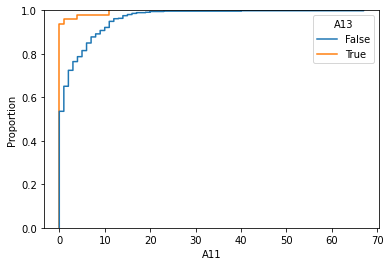

In [61]:
# Let's plot another variable with high PSI

sns.ecdfplot(data=X_train, x='A11', hue=tmp)

Now we can go ahead and drop the features from the train and test sets.

In [62]:
# print shape before dropping variables

X_train.shape, X_test.shape

((621, 15), (69, 15))

In [63]:
X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)

# print shape **after** dropping variables

X_train.shape, X_test.shape

((621, 9), (69, 9))

## Split based on Date

If our data had a valid timestamp, we could want to compare the distributions before and after a time point.

In [64]:
# Let's find out which are the minimum
# and maximum dates in our dataset

data['date'].agg(['min', 'max'])

min   2018-01-01
max   2019-11-21
Name: date, dtype: datetime64[ns]

In [65]:
# Now, we split the data into a train and a test set

X_train, X_test, y_train, y_test = train_test_split(
    data[vars_cat+vars_num+['date']],
    data['A16'],
    test_size=0.1,
    random_state=42,
)

In [66]:
# And we specify a transformer to split based
# on dates

transformer = DropHighPSIFeatures(
    cut_off =  pd.to_datetime('2018-12-14'), # the cut_off date
    split_col='date', # the date variable
    strategy = 'equal_frequency',
    bins=8,
    threshold=0.1,
    missing_values='ignore',
)

In [67]:
# Now we fit the transformer to the train set
# Here, the transformer will split the data, 
# determine the PSI of each feature and identify
# those that will be removed.

transformer.fit(X_train)

DropHighPSIFeatures(bins=8, cut_off=Timestamp('2018-12-14 00:00:00'),
                    missing_values='ignore', split_col='date', threshold=0.1)

In [68]:
# We specified the cut_off, so we should see
# our value here

transformer.cut_off_

Timestamp('2018-12-14 00:00:00')

In [69]:
# The transformer stores the PSI values of the variables

transformer.psi_values_

{'A2': 0.042897461606348365,
 'A3': 0.12454277821334697,
 'A8': 0.3103787266508977,
 'A11': 0.18886985933386097,
 'A14': 0.031337238449971605,
 'A15': 0.05807864506797143}

In [70]:
# The variables that will be dropped.

transformer.features_to_drop_

['A3', 'A8', 'A11']

To understand what the DropHighPSIFeatures is doing, let's split the train set manually, in the same what that the transformer is doing. Then, let's plot the distribution of the variables in each of the sub-dataframes.

Text(0.5, 1.0, 'A3 - moderately big PSI')

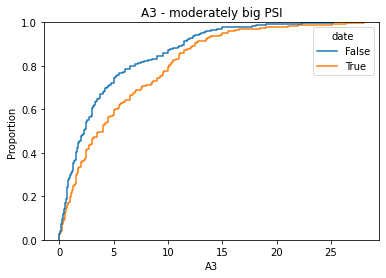

In [71]:
# Let's plot the variables distribution
# in each of the dataset portions

# create series to flag if an observation belongs to
# the base or comparison dataframe.

# Note how we use the cut_off identified by the
# transformer
tmp = X_train['date'] <= transformer.cut_off_

# plot
sns.ecdfplot(data=X_train, x='A3', hue=tmp)
plt.title('A3 - moderately big PSI')

<AxesSubplot:xlabel='A14', ylabel='Proportion'>

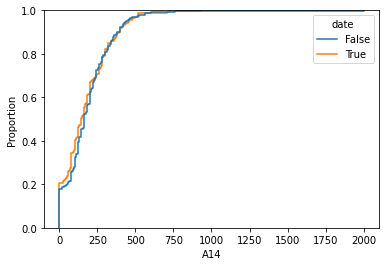

In [72]:
# For comparison, let's plot a variable with low PSI

sns.ecdfplot(data=X_train, x='A14', hue=tmp)

Now we can go ahead and drop the features from the train and test sets.

In [73]:
# print shape before dropping variables

X_train.shape, X_test.shape

((621, 16), (69, 16))

In [74]:
X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)

# print shape **after** dropping variables

X_train.shape, X_test.shape

((621, 13), (69, 13))

That is all!

I hope I gave you a good idea about how we can use this transformer to select features based on the Population Stability Index.